In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, feature
from scipy.stats import entropy
from itertools import chain

# Entrenamiento

In [ ]:
def GLCM(m,distancia,A,scale):
  '''
  m: matriz inicial
  distancia: distancia de movimiento 
  A: ángulo
  Scale: tamaño de la matriz de co-ocurrencia
  '''
  glcm = np.zeros((scale,scale))
  width, height = m.shape 
  for x in range(width):
    for y in range(height):
      if A==0:#Dirección 0 °
        if y+distancia < height: # Verificación fuera de límites 
          glcm[m[x][y]][m[x][y+distancia]] += 1

      elif A==45:
        if (x-distancia) >= 0 and 0 < y-distancia:# Verificación fuera de límites
          glcm[m[x][y]][m[x-distancia][y-distancia]] += 1
                  
      elif A==90: # Verificación fuera de límites
        if x+distancia < width:
          glcm[m[x][y]][m[x+distancia][y]] += 1

      elif A==135:
        if (y-distancia) >= 0 and x+distancia < width: # Verificación fuera de límites  
          glcm[m[x][y]][m[x+distancia][y-distancia]] += 1
    #Verificar si la matriz es simetrica 
  if  np.array_equal(glcm, glcm.T) != type('True'):
    glcm=glcm+glcm.T
      #return vectorizar(glcm.astype("int32"))
    #else:
  return vectorizar(glcm.astype("int32"))

In [ ]:
def vectorizar(glcm):
  var = glcm.var()
  mean = glcm.mean()
  std = glcm.std()

  glcm_h = glcm.reshape((-1,1))
  h = entropy(glcm_h, base=2)

  return [mean, var, std, h[0]]

In [ ]:
def generar_pruebas(imagen, distancia, tamaño):

  n = distancia*2+1
  
  ventanas = list()
  for i in range(0,tamaño-n,distancia):
    for j in range(0,tamaño-n,distancia):
      ventanas.append(imagen[i:i+n,j:j+n])
      
  return ventanas

def etiquetar(lista_muestras, etiqueta):

  return [(x, etiqueta) for x in lista_muestras]

In [ ]:
def sacar_pruebas(url, distancia, angulo, etiqueta):
  # cargamos la imágen
  img = io.imread(url)
  data = img[:,:,0]

  # establecemos el valor posible de pixeles
  escala = 256

  # Se generan las pruebas
  lista_pruebas = generar_pruebas(data, distancia, data.shape[0])

  # Generamos las glcm de cada prueba y calculamos los vectores de las pruebas
  lista_pruebas_vectores = [GLCM(ventana, distancia, angulo, escala) for ventana in lista_pruebas]

  # etiquetamos los vectores
  lista_pruebas_vectores_etiquetados = etiquetar(lista_pruebas_vectores, etiqueta)

  return lista_pruebas_vectores_etiquetados

In [ ]:
# para una sola
#pruebas = sacar_pruebas("/content/D1.bmp",2,"1")

In [ ]:
# para generar el train-set hay que hacerlo para todas las texturas
texturas_url = [
                #(url, etiqueta)
                ("/content/D6.bmp","1"), ("/content/D64.bmp","2"), ("/content/D49.bmp","3"), ("/content/D101.bmp","4"),
                ]

#Cambié la distancia a 16
train_set = [sacar_pruebas(url,16,45,etq) for url,etq in texturas_url]

In [ ]:
# encadenamos las pruebas
train_set_new = list()
for lista in train_set:
  train_set_new.extend(lista)
train_set = train_set_new

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
# Con el clasificador de bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

#Para la validación de ambos métodos. 
from sklearn.model_selection import cross_val_score

In [ ]:
np.random.shuffle(train_set)

In [ ]:
X = np.array([x[0] for x in train_set])
y = np.array([x[1] for x in train_set])

**Clasificador Bayesiana (Naive Bayes).**

In [ ]:
clf = MultinomialNB()
clf.fit(X, y)
print(clf.predict(X[2:3])) # [2]

['2']


Validación del modelo usando *Cross-Validation*

In [ ]:
from sklearn.model_selection import cross_val_score
cv_NB = cross_val_score(clf, X, y, cv = 4) #cv es el número de grupos en el cual
                                            #será dividida la data de entrenamiento

print(cv_NB)
print("Media de los 4 resultados: {}" .format(np.mean(cv_NB)))
clf.score(X,y)

Validación usando el método *score* de MultinomialNB

In [ ]:
clf.score(X,y)

**Clasificador K vecinos más cercanos(K nearest neighbours)**

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X, y)

#print(neigh.predict([[1.1]]))

KNeighborsClassifier(n_neighbors=4)

 Validación del modelo usando Cross-Validation

In [ ]:
cv_KNN = cross_val_score(neigh, X, y, cv = 4) #cv es el número de grupos en el cual
                                                #será dividida la data de entrenamiento

print(cv_KNN)
print("Media de los 4 resultados: {}" .format(np.mean(cv_KNN)))

Validación usando el método *score* de KNeighborsClassifier

In [ ]:
neigh.score(X,y)

# Pruebas

In [ ]:
def generar_prediccion(imagen, distancia, tamaño,angulo,escala, clasificador):

  n = distancia*2+1
  
  nuevaimagen = np.zeros_like(imagen)
  for i in range(0,tamaño-n,distancia):
    for j in range(0,tamaño-n,distancia):
      Vector_Prediccion=GLCM((imagen[i:i+n,j:j+n]),distancia,angulo,escala)
      Solucion=clasificador.predict([Vector_Prediccion])
      nuevaimagen[i:i+n,j:j+n]=85*int(Solucion[0])
  return nuevaimagen


In [ ]:

data = io.imread("/content/imgCompuesta1.png")
escala = 256
img1n = generar_prediccion(data, 2, data.shape[0],45,escala, neigh)
img1n


array([[170, 170,  85, ..., 170, 170,   0],
       [170, 170,  85, ..., 170, 170,   0],
       [170, 170, 170, ..., 170, 170,   0],
       ...,
       [ 85,  85, 255, ...,  84,  84,   0],
       [ 85,  85, 255, ...,  84,  84,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

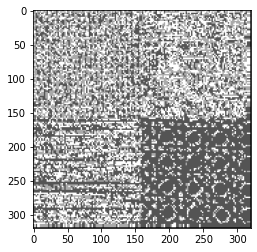

In [ ]:
from google.colab.patches import cv2_imshow
plt.imshow(img1n,cmap='gray')

In [ ]:
data = io.imread("/content/imgCompuesta2.png")
escala = 256
img2n = generar_prediccion(data, 2, data.shape[0],45,escala, neigh)
img2n

array([[ 85,  85, 255, ..., 170, 170,   0],
       [ 85,  85, 255, ..., 170, 170,   0],
       [170, 170, 170, ..., 170, 170,   0],
       ...,
       [255, 255,  85, ...,  84,  84,   0],
       [255, 255,  85, ...,  84,  84,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

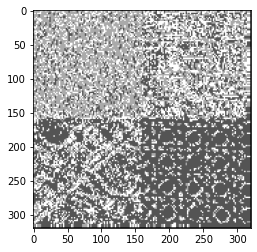

In [ ]:
from google.colab.patches import cv2_imshow
plt.imshow(img2n,cmap='gray')

In [ ]:
data = io.imread("/content/imgCompuesta3.png")
escala = 256
img3n = generar_prediccion(data, 2, data.shape[0],45,escala, neigh)
img3n

array([[ 84,  84,  84, ..., 170, 170,   0],
       [ 84,  84,  84, ..., 170, 170,   0],
       [ 84,  84,  84, ..., 170, 170,   0],
       ...,
       [255, 255,  85, ..., 255, 255,   0],
       [255, 255,  85, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

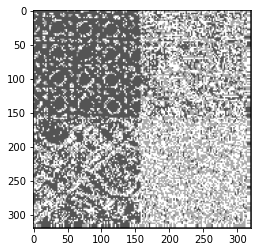

In [ ]:
from google.colab.patches import cv2_imshow
plt.imshow(img3n,cmap='gray')

In [ ]:
data = io.imread("/content/PiedrasCompuesta.png")
escala = 256
Piedrasn = generar_prediccion(data[:,:,0], 2, data.shape[0],45,escala, neigh)
Piedrasn

array([[170, 170, 170, ..., 170,   0,   0],
       [170, 170, 170, ..., 170,   0,   0],
       [255, 255, 170, ..., 170,   0,   0],
       ...,
       [170, 170, 170, ..., 170,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

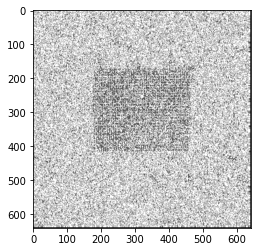

In [ ]:
from google.colab.patches import cv2_imshow
plt.imshow(Piedrasn, cmap='gray')

In [ ]:
data = io.imread("/content/PiedrasCompuesta.png")
escala = 256
Piedras = generar_prediccion(data[:,:,0], 1, data.shape[0],45,escala, clf)
Piedras

array([[170, 170, 170, ...,  84,  84,   0],
       [170, 170, 170, ..., 170, 170,   0],
       [170, 170, 170, ..., 170, 170,   0],
       ...,
       [170, 170, 170, ..., 170, 170,   0],
       [170, 170, 170, ..., 170, 170,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

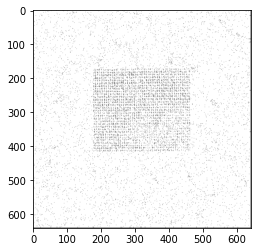

In [ ]:
from google.colab.patches import cv2_imshow
plt.imshow(Piedras,cmap='gray')